# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np


For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Load the dataset from your Drive folder

train = loadmat('gdrive/MyDrive/Colab Notebooks/data/train_32x32.mat')
test = loadmat('gdrive/MyDrive/Colab Notebooks/data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [4]:
X_train = train['X']
y_train = train['y']
X_test = test['X']
y_test = test['y']

In [5]:
# Checking the shapes

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (32, 32, 3, 73257)
y_train shape: (73257, 1)
X_test shape: (32, 32, 3, 26032)
y_test shape: (26032, 1)


In [6]:
# For training we need the batch dimension in the first position

X_train = np.moveaxis(X_train, -1, 0)
X_test = np.moveaxis(X_test, -1, 0)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_train.shape)


X_train shape: (73257, 32, 32, 3)
X_test shape: (73257, 32, 32, 3)


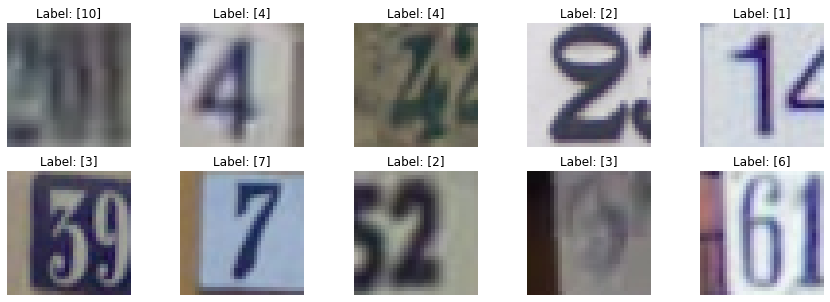

In [7]:
%matplotlib inline

random_sample = np.random.randint(0, 73256, 10)
# Creates an random array to select images from the dataset

fig, axs = plt.subplots(2,5, figsize=(15,5))

j = 0

for i,v in enumerate(random_sample):
  if i>=5: 
    j = 1
    i -= 5
  axs[j][i].set_axis_off()
  axs[j][i].imshow(X_train[v,:,:,:])
  caption = 'Label: ' + str(y_train[v,:])
  axs[j][i].set_title(caption)

fig.show()

In [8]:
# Now we convert the training an testing images to grayscale

X_train = X_train.mean(axis=3, keepdims=True)
X_test = X_test.mean(axis=3, keepdims=True)

In [9]:
# If we set the last layer to have a softmax activation with 10 units, 
# and we use sparse categorical crossentropy, this will try to categorize 
# the labels in the range from 0 to 9, but the tags are given from 1 to 10,
# therefore, we need to change de 10s by 0s to keep the tags between the
# needed range.

y_train = np.where(y_train==10, 0, y_train)
y_test = np.where(y_test==10, 0, y_test)

In [10]:
# We divide by 255 to get all the values between 0 and 1.

X_train = X_train  / 255
X_test = X_test / 255

In [11]:
# Checking the shape after these changes

print('X_train shape:', X_train.shape)
print('X_test shape:', X_train.shape)

X_train shape: (73257, 32, 32, 1)
X_test shape: (73257, 32, 32, 1)


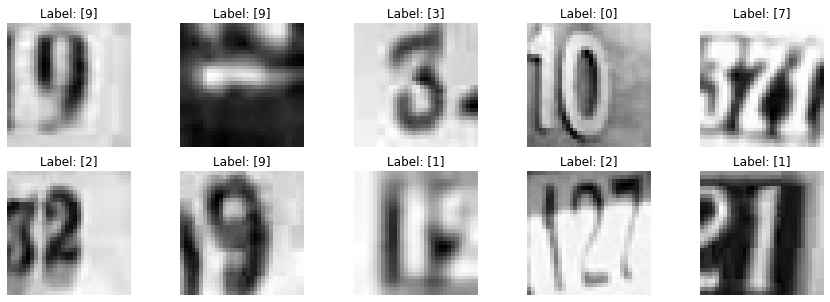

In [12]:
%matplotlib inline

random_sample = np.random.randint(0, 73256, 10)
# Creates an random array to select images from the dataset

fig, axs = plt.subplots(2,5, figsize=(15,5))

j = 0

for i,v in enumerate(random_sample):
  if i>=5: 
    j = 1
    i -= 5
  axs[j][i].set_axis_off()
  axs[j][i].imshow(X_train[v,:,:,0], cmap='gray')
  caption = 'Label: ' + str(y_train[v,:])
  axs[j][i].set_title(caption)

fig.show()

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [13]:
MLP_model = Sequential([
                        Flatten(input_shape=X_train[0].shape),
                        Dense(512, activation='relu'),
                        Dense(256, activation='relu'),
                        BatchNormalization(),
                        Dense(256, activation='relu'),
                        Dropout(0.5),
                        Dense(128, activation='relu'),
                        Dense(10, activation='softmax')
])

In [14]:
MLP_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

In [15]:
opt = tf.keras.optimizers.Adam(learning_rate=0.006)

MLP_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Instantiation of the callbacks

checkpoint_path = 'gdrive/MyDrive/Colab Notebooks/Capstone_Project/MPL/checkpoint'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1,
                             save_best_only=True, save_weights_only=True)

earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0)

In [17]:
MLP_history = MLP_model.fit(X_train, y_train, epochs=30, batch_size=64,
                    callbacks=[checkpoint, earlystopping],
                    validation_split=0.15, verbose=1)

Epoch 1/30
973/973 [==============================] - 6s 4ms/step - loss: 2.2174 - accuracy: 0.1975 - val_loss: 2.0507 - val_accuracy: 0.2432

Epoch 00001: val_loss improved from inf to 2.05074, saving model to gdrive/MyDrive/Colab Notebooks/Capstone_Project/MPL/checkpoint
Epoch 2/30
973/973 [==============================] - 3s 3ms/step - loss: 1.9820 - accuracy: 0.2813 - val_loss: 1.9294 - val_accuracy: 0.3235

Epoch 00002: val_loss improved from 2.05074 to 1.92941, saving model to gdrive/MyDrive/Colab Notebooks/Capstone_Project/MPL/checkpoint
Epoch 3/30
973/973 [==============================] - 3s 3ms/step - loss: 1.5845 - accuracy: 0.4489 - val_loss: 1.4111 - val_accuracy: 0.5180

Epoch 00003: val_loss improved from 1.92941 to 1.41107, saving model to gdrive/MyDrive/Colab Notebooks/Capstone_Project/MPL/checkpoint
Epoch 4/30
973/973 [==============================] - 3s 3ms/step - loss: 1.4109 - accuracy: 0.5253 - val_loss: 1.3504 - val_accuracy: 0.5641

Epoch 00004: val_loss impro

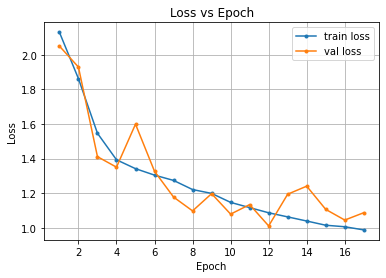

In [18]:
x = np.arange(1, len(MLP_history.history.get('loss'))+1)
y1 = MLP_history.history.get('loss')
y2 = MLP_history.history.get('val_loss')



fig, ax = plt.subplots()
plt.plot(x, y1, marker='.', label = 'train loss')
plt.plot(x, y2, marker='.', label = 'val loss')


ax.set(xlabel='Epoch', ylabel='Loss',
       title='Loss vs Epoch')
plt.legend()
ax.grid()
plt.show()

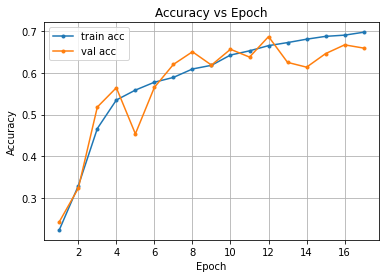

In [19]:
x = np.arange(1, len(MLP_history.history.get('accuracy'))+1)
y1 = MLP_history.history.get('accuracy')
y2 = MLP_history.history.get('val_accuracy')


fig, ax = plt.subplots()
plt.plot(x, y1, marker='.', label = 'train acc')
plt.plot(x, y2, marker='.', label = 'val acc')


ax.set(xlabel='Epoch', ylabel='Accuracy',
       title='Accuracy vs Epoch')
plt.legend()
ax.grid()
plt.show()

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [20]:
CNN_model = Sequential([
                         Conv2D(12,(4,4),padding='SAME', activation='relu', input_shape=X_train[0].shape),
                         Conv2D(24,(16,16),padding='SAME', activation='relu'),
                         MaxPool2D(5,5),
                         Flatten(),
                         BatchNormalization(),
                         Dense(128, activation='relu'),
                         Dropout(0.25),
                         Dense(128, activation='relu'),
                         Dropout(0.25),
                         Dense(64, activation='relu'),
                         Dense(10, activation='softmax')

])

In [21]:
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 12)        204       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 24)        73752     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 24)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 864)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 864)               3456      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               110720    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [22]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0003)

CNN_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [23]:
# Instantiation of the callbacks for the CNN

checkpoint_path = 'gdrive/MyDrive/Colab Notebooks/Capstone_Project/CNN/checkpoint'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1,
                             save_best_only=True, save_weights_only=True)

earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0)

In [24]:
CNN_history = CNN_model.fit(X_train, y_train, batch_size=64, epochs=30,
                             verbose=1, callbacks=[checkpoint, earlystopping],
                             validation_split=0.15)

Epoch 1/30
973/973 [==============================] - 12s 6ms/step - loss: 1.4926 - accuracy: 0.4817 - val_loss: 0.4956 - val_accuracy: 0.8468

Epoch 00001: val_loss improved from inf to 0.49558, saving model to gdrive/MyDrive/Colab Notebooks/Capstone_Project/CNN/checkpoint
Epoch 2/30
973/973 [==============================] - 6s 6ms/step - loss: 0.5533 - accuracy: 0.8283 - val_loss: 0.4090 - val_accuracy: 0.8760

Epoch 00002: val_loss improved from 0.49558 to 0.40900, saving model to gdrive/MyDrive/Colab Notebooks/Capstone_Project/CNN/checkpoint
Epoch 3/30
973/973 [==============================] - 6s 6ms/step - loss: 0.4554 - accuracy: 0.8613 - val_loss: 0.3744 - val_accuracy: 0.8881

Epoch 00003: val_loss improved from 0.40900 to 0.37444, saving model to gdrive/MyDrive/Colab Notebooks/Capstone_Project/CNN/checkpoint
Epoch 4/30
973/973 [==============================] - 6s 6ms/step - loss: 0.4042 - accuracy: 0.8765 - val_loss: 0.3544 - val_accuracy: 0.8952

Epoch 00004: val_loss impr

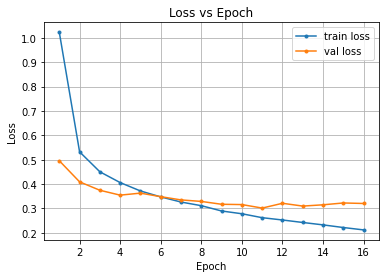

In [25]:
x = np.arange(1, len(CNN_history.history.get('loss'))+1)
y1 = CNN_history.history.get('loss')
y2 = CNN_history.history.get('val_loss')



fig, ax = plt.subplots()
plt.plot(x, y1, marker='.', label = 'train loss')
plt.plot(x, y2, marker='.', label = 'val loss')


ax.set(xlabel='Epoch', ylabel='Loss',
       title='Loss vs Epoch')
plt.legend()
ax.grid()
plt.show()

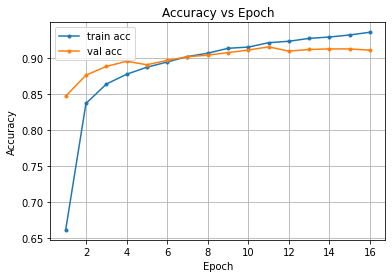

In [26]:
x = np.arange(1, len(CNN_history.history.get('accuracy'))+1)
y1 = CNN_history.history.get('accuracy')
y2 = CNN_history.history.get('val_accuracy')


fig, ax = plt.subplots()
plt.plot(x, y1, marker='.', label = 'train acc')
plt.plot(x, y2, marker='.', label = 'val acc')


ax.set(xlabel='Epoch', ylabel='Accuracy',
       title='Accuracy vs Epoch')

plt.legend()
ax.grid()
plt.show()

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [27]:
MLP_checkpoint_path = 'gdrive/MyDrive/Colab Notebooks/Capstone_Project/MPL/checkpoint'
CNN_checkpoint_path = 'gdrive/MyDrive/Colab Notebooks/Capstone_Project/CNN/checkpoint'


MLP_model.load_weights(MLP_checkpoint_path)
CNN_model.load_weights(CNN_checkpoint_path)

In [28]:
X_test[25,:,:,:].reshape(-1,32,32,1).shape

(1, 32, 32, 1)

In [29]:
MLP_model.predict(X_test[25,:,:,:].reshape(-1,32,32,1))

array([[1.07381293e-05, 8.80978405e-06, 1.17366944e-04, 2.17769593e-02,
        3.52572897e-05, 9.32906330e-01, 7.29404949e-03, 2.76616925e-06,
        3.71413119e-02, 7.06438150e-04]], dtype=float32)

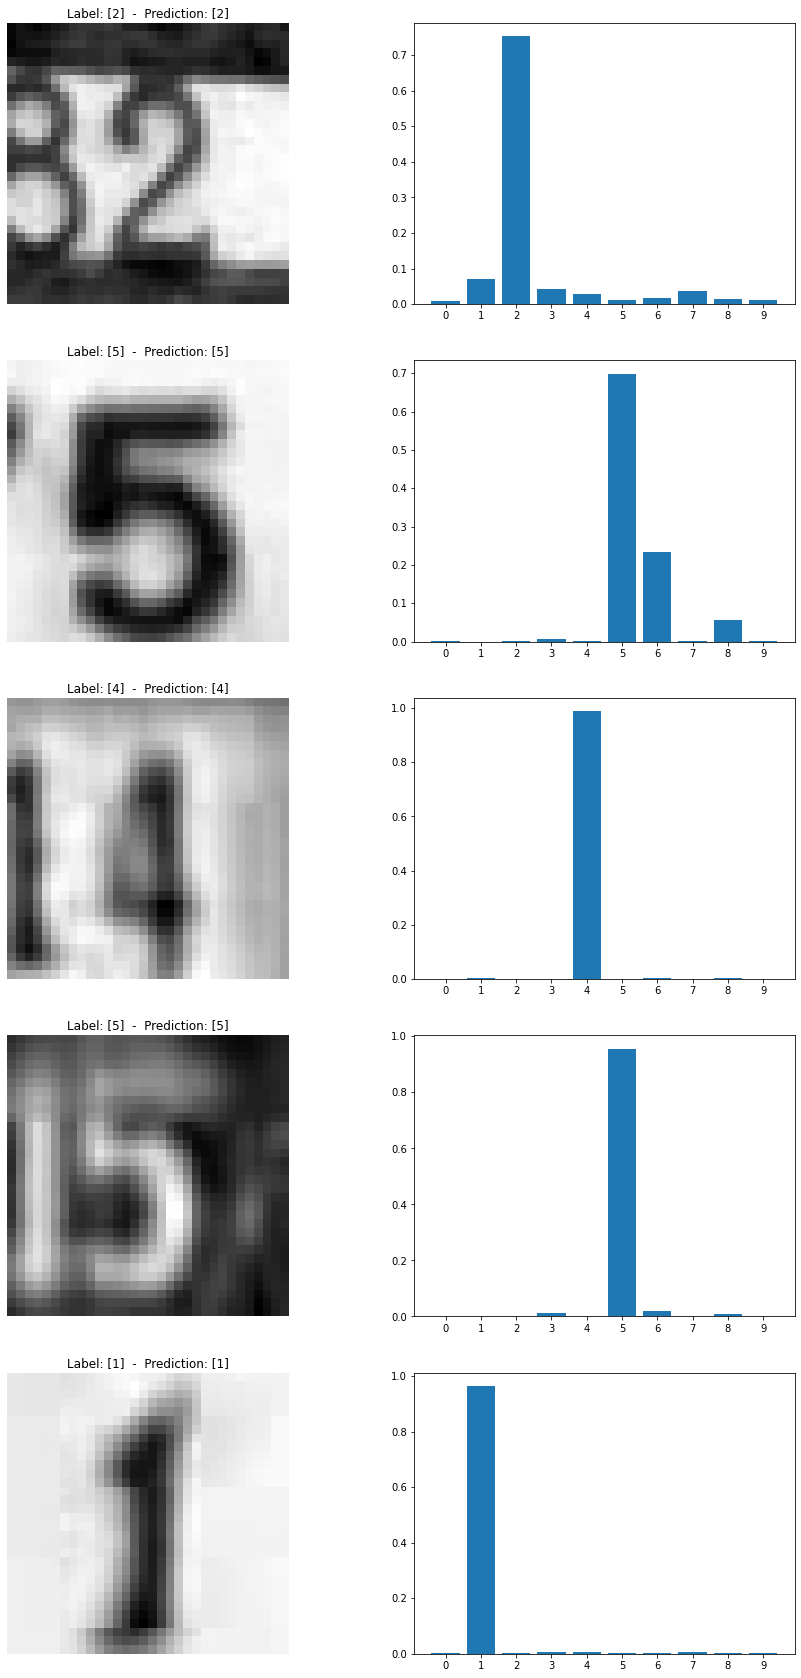

In [30]:
random_sample = np.random.randint(0, 26031, 5)

fig, axs = plt.subplots(5,2, figsize=(15,30))

x = np.arange(10).astype(str)


for i,v in enumerate(random_sample):
  predictions = MLP_model.predict(X_test[v,:,:,:].reshape(-1,32,32,1))
  axs[i, 0].set_axis_off()
  axs[i, 0].imshow(X_test[v,:,:,0], cmap='gray')
  caption = 'Label: ' + str(y_test[v,:]) + '  -  Prediction: [' + str(predictions.argmax()) + ']'
  axs[i, 0].set_title(caption)
  axs[i, 1].bar(x, predictions.reshape(-1,))

fig.show()

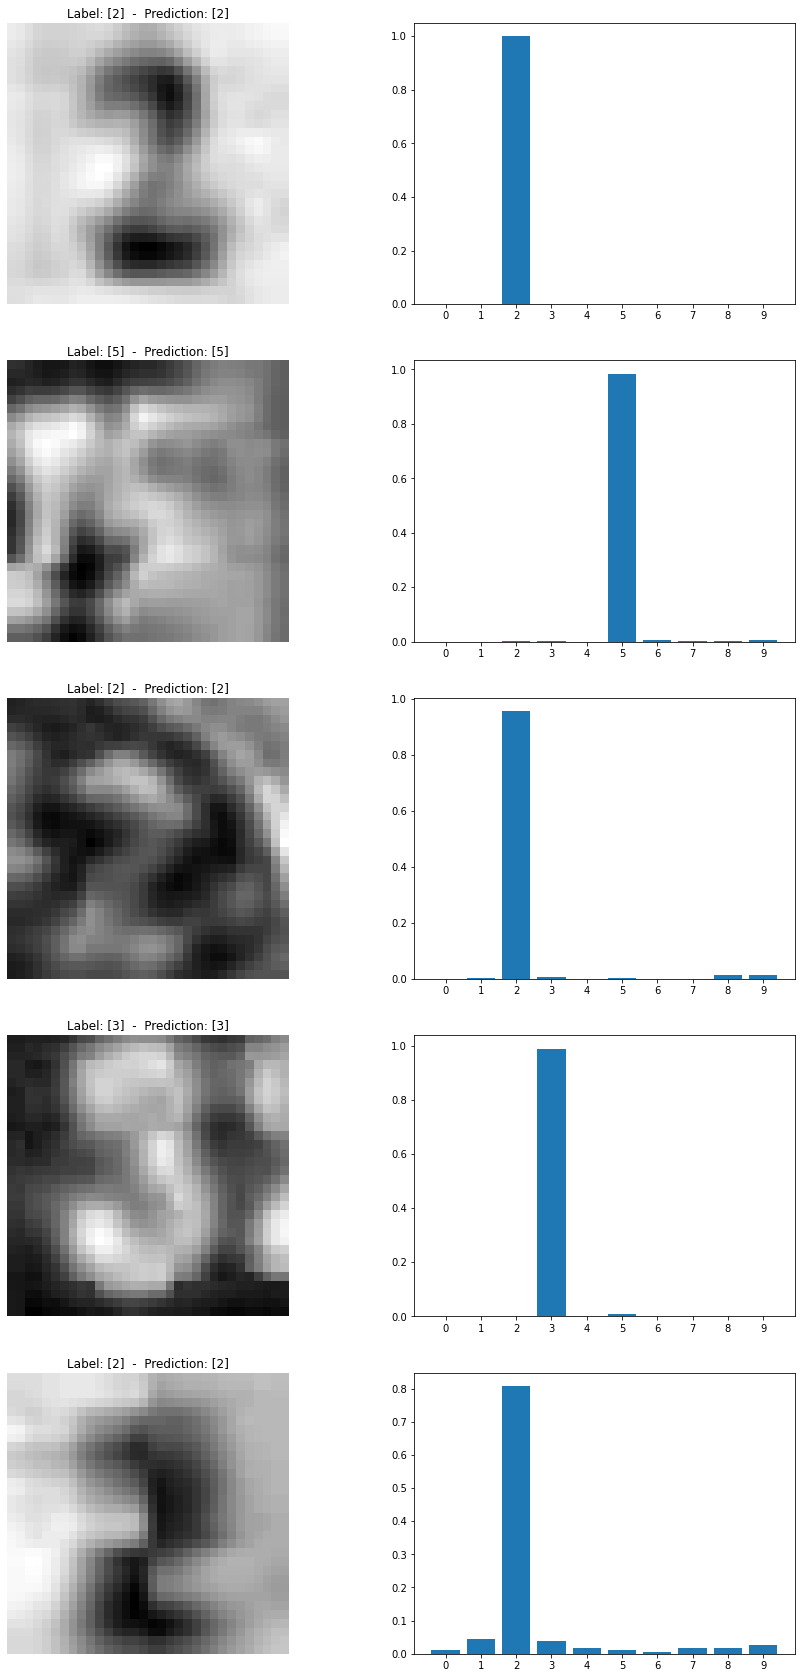

In [31]:
random_sample = np.random.randint(0, 26031, 5)

fig, axs = plt.subplots(5,2, figsize=(15,30))

x = np.arange(10).astype(str)


for i,v in enumerate(random_sample):
  predictions = CNN_model.predict(X_test[v,:,:,:].reshape(-1,32,32,1))
  axs[i, 0].set_axis_off()
  axs[i, 0].imshow(X_test[v,:,:,0], cmap='gray')
  caption = 'Label: ' + str(y_test[v,:]) + '  -  Prediction: [' + str(predictions.argmax()) + ']'
  axs[i, 0].set_title(caption)
  axs[i, 1].bar(x, predictions.reshape(-1,))

fig.show()

In [32]:
# Finally, we will evaluate the overall performance of both models in the test set

print(' ----- MLP Model evaluation -----')

NPL_test = MLP_model.evaluate(X_test, y_test)

print('\nLoss:{:.04f}'.format(NPL_test[0]))
print('Accuracy:{:.02f}%\n\n'.format(NPL_test[1]*100))


print(' ----- CNN Model evaluation ----- ')

CNN_test = CNN_model.evaluate(X_test, y_test)

print('\nLoss:{:.04f}'.format(CNN_test[0]))
print('Accuracy:{:.02f}%'.format(CNN_test[1]*100))

 ----- MLP Model evaluation -----
814/814 [==============================] - 2s 2ms/step - loss: 1.0794 - accuracy: 0.6705

Loss:1.0794
Accuracy:67.05%


 ----- CNN Model evaluation ----- 
814/814 [==============================] - 2s 2ms/step - loss: 0.3588 - accuracy: 0.8981

Loss:0.3588
Accuracy:89.81%
